In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")
print(regions_gdf.crs)
print(rgi_gdf.crs)

ESRI:102025
ESRI:102025


In [4]:
# add the o3region as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"o3region"}, axis=1)
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["o3region","geometry"]])

In [5]:
all_regions = np.unique(rgi_gdf['o3region'].values)
c=0
for r in all_regions:
    # if r!=1: continue
    print("Starting region", r)
    
    # subset to the rgi in this region
    gdf_susbet = rgi_gdf[rgi_gdf['o3region']==r]
    
    # define path to the region's water count
    path_open = os.path.join(folder_HMA, "Datasets", "GEE outputs", "water counts",
                             f"water_count_r{str(r).zfill(2)}_acca.tif")
    
    # open with riox
    xr_water = riox.open_rasterio(path_open, masked=False,
                                   chunks={"x": 'auto', "y": 'auto'}).astype(float)
    
    # rename bands to the years which they represent
    year_names = [i for i in list(xr_water.long_name)]
    xr_water = xr_water.rename({"band":"year"})
    xr_water['year'] = year_names
    xr_water = xr_water.to_dataset(dim='year')
    
    # define path to the region's usable count
    path_open = os.path.join(folder_HMA, "Datasets", "GEE outputs", "usable counts",
                             f"usable_count_r{str(r).zfill(2)}_acca.tif")
    
    # open with riox
    xr_usable = riox.open_rasterio(path_open, masked=True,
                                   chunks={"x": 'auto', "y": 'auto'}).astype(float)
    
    # rename bands to the years which they represent
    year_names = [i for i in list(xr_usable.long_name)]
    xr_usable = xr_usable.rename({"band":"year"})
    xr_usable['year'] = year_names
    xr_usable = xr_usable.to_dataset(dim='year') # to dataset so we save band names
    
    # process each glacier
    for idx, row in gdf_susbet.iterrows():
        c+=1
        # if c>1: continue

        # grab glacier geometry, region, rgiid
        rgi_id = row['rgi_id']
        region = row['o3region']
        geom = row['geometry']
        
        # print progress
        # print(r, c, "of", len(rgi_gdf), rgi_id)
        if c%10==0: print(r, c, "of", len(rgi_gdf), rgi_id)
        
        # open glacier mask
        path_mask = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'glacier_mask.tif')
        xr_mask = riox.open_rasterio(path_mask, masked=True).squeeze(drop=True)

        # subset water, usable to the extent of the mask (buffered by a bit)
        xs = [ np.nanmin(xr_mask['x'])-200, np.nanmax(xr_mask['x'])+200 ]
        ys = [ np.nanmin(xr_mask['y'])-200, np.nanmax(xr_mask['y'])+200 ]
        xr_water_subset = xr_water.sel(x=slice(xs[0], xs[1]), y=slice(ys[1], ys[0]))
        xr_usable_subset = xr_usable.sel(x=slice(xs[0], xs[1]), y=slice(ys[1], ys[0]))
        
        
        # clip the water xr to the rgi geometry (buffered by a little bit), fill nan with 0
        xr_water_clipped = xr_water_subset.rio.clip([geom.buffer(200)])
        xr_water_clipped = xr_water_clipped.where(~np.isnan(xr_water_clipped), 0)
        
        # interpolate to the mask grid
        xr_water_interp = xr_water_clipped.interp_like(xr_mask, method='nearest', assume_sorted=False)
        xr_water_interp = xr_water_interp.where(xr_mask>0, np.nan)
        
        
        # clip the water xr to the rgi geometry (buffered by a little bit), fill nan with 0
        xr_usable_clipped = xr_usable_subset.rio.clip([geom.buffer(200)])
        xr_usable_clipped = xr_usable_clipped.where(~np.isnan(xr_usable_clipped), 0)
        
        # interpolate to the mask grid
        xr_usable_interp = xr_usable_clipped.interp_like(xr_mask, method='nearest', assume_sorted=False)
        xr_usable_interp = xr_usable_interp.where(xr_mask>0, np.nan)
        
        # we need a different xr_usable_interp product to avoid throwing divide errors when 0
        # these pixels will end up being 0 regardless of what is in denominator, so just set to 1
        usable_divide = xr_usable_interp.where(xr_usable_interp>0, 1)

        # calculate water percent
        xr_percent_water = xr_water_interp/usable_divide
        
        
        # save as geotiffs
        out_path = os.path.join(folder_glaciers, rgi_id, 'Water', 'glacier_water_count_acca.tif')
        xr_water_interp.rio.to_raster(out_path, compress='LZW', tiled=True)
        
        # save as geotiffs
        # xr_usable_interp = xr_usable_interp.where(xr_mask>0, np.nan)
        out_path = os.path.join(folder_glaciers, rgi_id, 'Usable', 'glacier_usable_count_acca.tif')
        xr_usable_interp.rio.to_raster(out_path, compress='LZW', tiled=True)
        
        # save as geotiffs
        out_path = os.path.join(folder_glaciers, rgi_id, 'Water', 'glacier_water_frequency_acca.tif')
        xr_percent_water.rio.to_raster(out_path, compress='LZW', tiled=True)
        
        # break
    # break
print("All done!")

Starting region 1
Starting region 2
2 10 of 769 RGI2000-v7.0-G-15-17006
Starting region 3
3 20 of 769 RGI2000-v7.0-G-15-14828
Starting region 4
4 30 of 769 RGI2000-v7.0-G-13-69268
4 40 of 769 RGI2000-v7.0-G-13-71532
4 50 of 769 RGI2000-v7.0-G-13-71720
4 60 of 769 RGI2000-v7.0-G-13-73319
4 70 of 769 RGI2000-v7.0-G-15-11613
Starting region 5
5 80 of 769 RGI2000-v7.0-G-15-11027
Starting region 6
6 90 of 769 RGI2000-v7.0-G-15-09295
6 100 of 769 RGI2000-v7.0-G-15-09537
6 110 of 769 RGI2000-v7.0-G-15-10171
Starting region 7
7 120 of 769 RGI2000-v7.0-G-15-06654
7 130 of 769 RGI2000-v7.0-G-15-06827
7 140 of 769 RGI2000-v7.0-G-15-07190
7 150 of 769 RGI2000-v7.0-G-15-07878
7 160 of 769 RGI2000-v7.0-G-15-08080
7 170 of 769 RGI2000-v7.0-G-15-08356
7 180 of 769 RGI2000-v7.0-G-15-08688
Starting region 8
8 190 of 769 RGI2000-v7.0-G-15-04301
8 200 of 769 RGI2000-v7.0-G-15-04937
8 210 of 769 RGI2000-v7.0-G-15-05068
8 220 of 769 RGI2000-v7.0-G-15-05330
8 230 of 769 RGI2000-v7.0-G-15-05619
8 240 of 769 R

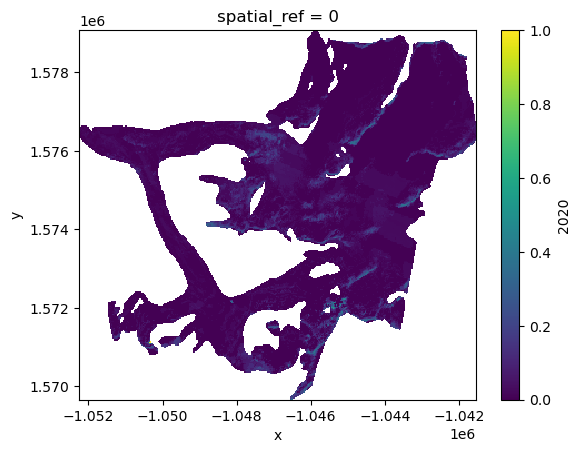

In [6]:
xr_percent_water['2020'].plot()

In [7]:
xr_water_interp

<xarray.Dataset>
Dimensions:      (y: 314, x: 357)
Coordinates:
    spatial_ref  int32 0
  * y            (y) float64 1.579e+06 1.579e+06 1.579e+06 ... 1.57e+06 1.57e+06
  * x            (x) float64 -1.052e+06 -1.052e+06 ... -1.042e+06 -1.042e+06
Data variables: (12/35)
    1989         (y, x) float64 dask.array<chunksize=(314, 357), meta=np.ndarray>
    1990         (y, x) float64 dask.array<chunksize=(314, 357), meta=np.ndarray>
    1991         (y, x) float64 dask.array<chunksize=(314, 357), meta=np.ndarray>
    1992         (y, x) float64 dask.array<chunksize=(314, 357), meta=np.ndarray>
    1993         (y, x) float64 dask.array<chunksize=(314, 357), meta=np.ndarray>
    1994         (y, x) float64 dask.array<chunksize=(314, 357), meta=np.ndarray>
    ...           ...
    2018         (y, x) float64 dask.array<chunksize=(314, 357), meta=np.ndarray>
    2019         (y, x) float64 dask.array<chunksize=(314, 357), meta=np.ndarray>
    2020         (y, x) float64 dask.array<chunksize=(314, 357), meta=np.ndarray>
    2021         (y, x) float64 dask.array<chunksize=(314, 357), meta=np.ndarray>
    2022         (y, x) float64 dask.array<chunksize=(314, 357), meta=np.ndarray>
    2023         (y, x) float64 dask.array<chunksize=(314, 357), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('1989', '1990', '1991', '1992', '1993', '1994', '1995', ...